In [8]:
source("common.R")

df_all <-
  read_csv("data/tidy_ons_longcovid.csv",
          col_types = "ccfd")%>%
  filter(Domain == "Duration since first (suspected) coronavirus infection")%>%
  filter(Group != "Unknown duration")%>%
  select(-Domain, -filename, -`Lower 95% confidence limit`, , -`Upper 95% confidence limit`)

df_all%>%
  head

Impact on daily activity,Group,Estimate,Date
<chr>,<fct>,<dbl>,<date>
Activity not limited,0 to <12 weeks,17,2023-03-05
Activity not limited,12 to <26 weeks,25,2023-03-05
Activity not limited,26 to <39 weeks,28,2023-03-05
Activity not limited,39 to <52 weeks,32,2023-03-05
Activity not limited,52 to <78 weeks,104,2023-03-05
Activity not limited,78 to <104 weeks,30,2023-03-05


In [3]:
skeleton <-
  data.frame(Year= seq(2021, 2023))%>%
  merge(data.frame(Week = seq(1, 52)))%>%
  merge(data.frame(`Impact on daily activity` = levels(as.factor(df_all$`Impact on daily activity`))))%>%
  merge(data.frame(`Group` = levels(as.factor(df_all$`Group`))))%>%
  filter(Group != "Unknown duration")%>%
  rename(`Impact on daily activity` = `Impact.on.daily.activity`)

levels <- c("Activity not limited", "Activity limited a little", "Activity limited a lot")

df2 <-
  df_all%>%

  spread("Group", "Estimate", fill = 0)%>%
  gather("Group", "Estimate", -`Impact on daily activity`, -Date)%>%

  mutate(`Impact on daily activity` = as.factor(`Impact on daily activity`))%>%
  mutate(`Impact on daily activity` = factor(`Impact on daily activity`, levels = levels))%>%

  mutate(ISOweek = ISOweek::ISOweek(Date))%>%
  separate(ISOweek, into = c("Year", "Week"), sep = "-W")%>%
  mutate(Year = as.integer(Year),
         Week = as.integer(Week))%>%
  select(-Date)%>%
  merge(skeleton, all = T)%>%
  arrange(Year, Week)%>%
  group_by(`Impact on daily activity`, `Group`)%>%
  mutate(Estimate = zoo::na.approx(Estimate, na.rm = F))%>%
  mutate(Estimate = ifelse(is.na(Estimate), 0, Estimate))%>%
  filter(Year*100 + Week >= 202117)%>%
  filter(Year*100 + Week <= 202309)

df2%>%tail

Impact on daily activity,Group,Year,Week,Estimate
<fct>,<chr>,<int>,<int>,<dbl>
Activity limited a lot,104+ weeks,2023,9,175
Activity limited a lot,12 to <26 weeks,2023,9,21
Activity limited a lot,26 to <39 weeks,2023,9,22
Activity limited a lot,39 to <52 weeks,2023,9,43
Activity limited a lot,52 to <78 weeks,2023,9,73
Activity limited a lot,78 to <104 weeks,2023,9,17


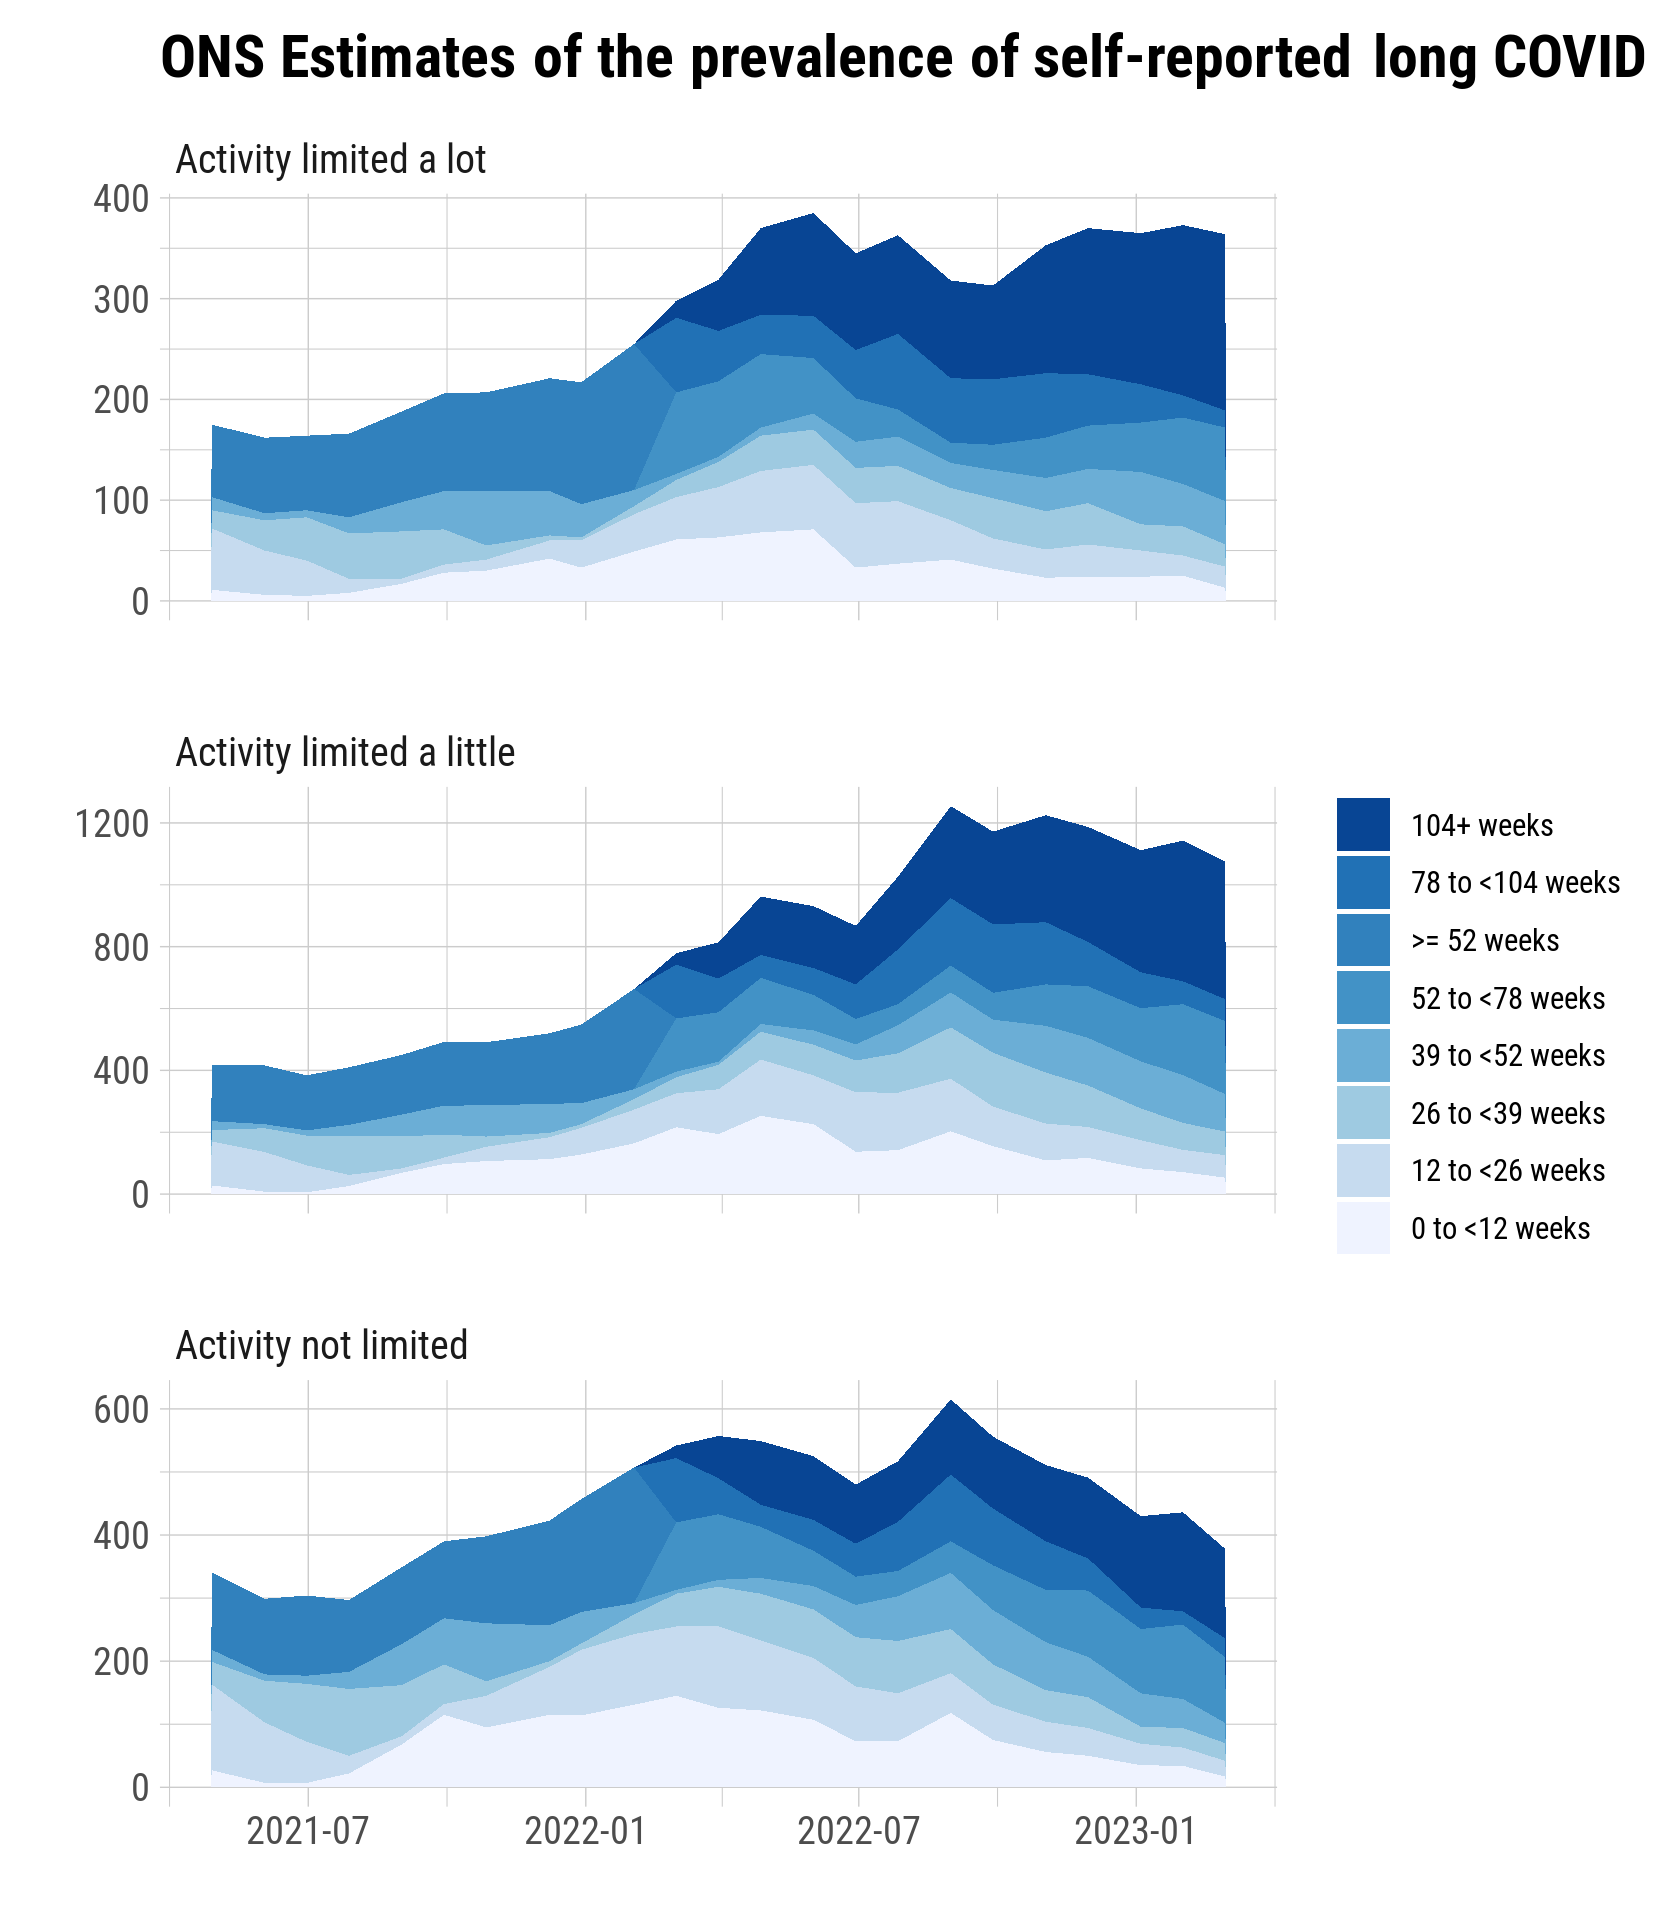

In [9]:
s = 1
options(repr.plot.width = s*7, repr.plot.height = s*8, repr.plot.res = 240/s)

df2%>%
  mutate(Date = ISOweek::ISOweek2date(paste0(Year, "-W", str_pad(Week, width = 2, pad = "0"), "-3")))%>%
  mutate(`Impact on daily activity` = factor(`Impact on daily activity`, levels = rev(levels)))%>%
  ggplot(aes(x = Date, y = Estimate, fill = reorder(Group, -parse_number(Group)))) + 
  labs(title = "ONS Estimates of the prevalence of self-reported long COVID",
       fill = "", x = "", y = "") +
  geom_area() +
  scale_fill_manual(values = rev(pal)) +
  facet_wrap(~`Impact on daily activity`, ncol = 1, scale = "free_y") +
  savePlot("ONS_LC_estimate1")

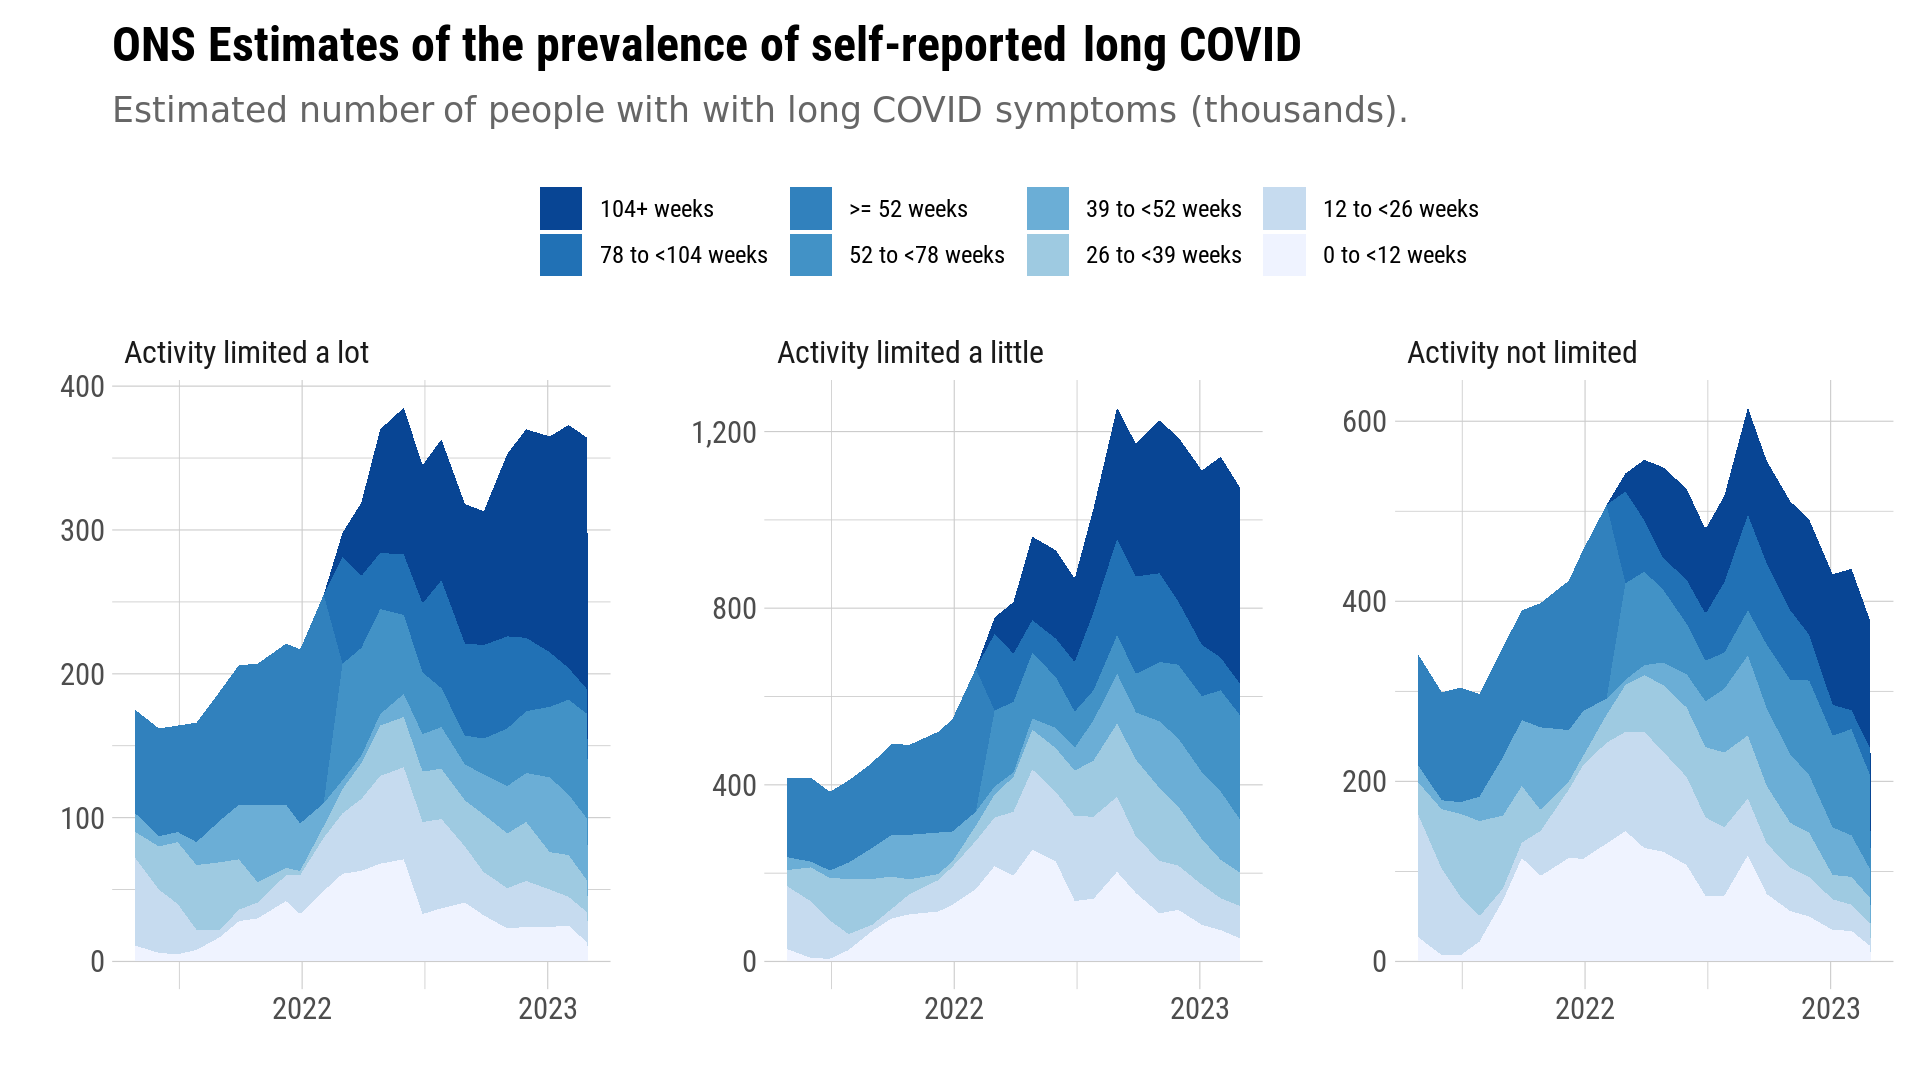

In [10]:
s = 1.25
options(repr.plot.width = s*8, repr.plot.height = s*4.5, repr.plot.res = 240/s)

df2%>%
  mutate(Date = ISOweek::ISOweek2date(paste0(Year, "-W", str_pad(Week, width = 2, pad = "0"), "-3")))%>%
  mutate(`Impact on daily activity` = factor(`Impact on daily activity`, levels = rev(levels)))%>%
  ggplot(aes(x = Date, y = Estimate, fill = reorder(Group, -parse_number(Group)))) + 
  labs(title = "ONS Estimates of the prevalence of self-reported long COVID",
       subtitle = "Estimated number of people with with long COVID symptoms (thousands).",
       fill = "", x = "", y = "") +
  geom_area() +
  scale_fill_manual(values = rev(pal)) +
  scale_x_date(date_breaks = "1 year", date_labels = "%Y") +

  scale_y_continuous(labels = scales::comma) +
  facet_wrap(~`Impact on daily activity`, ncol = 3, scale = "free_y") +
  theme(legend.position  = "top") +
  savePlot("ONS_LC_estimate2")


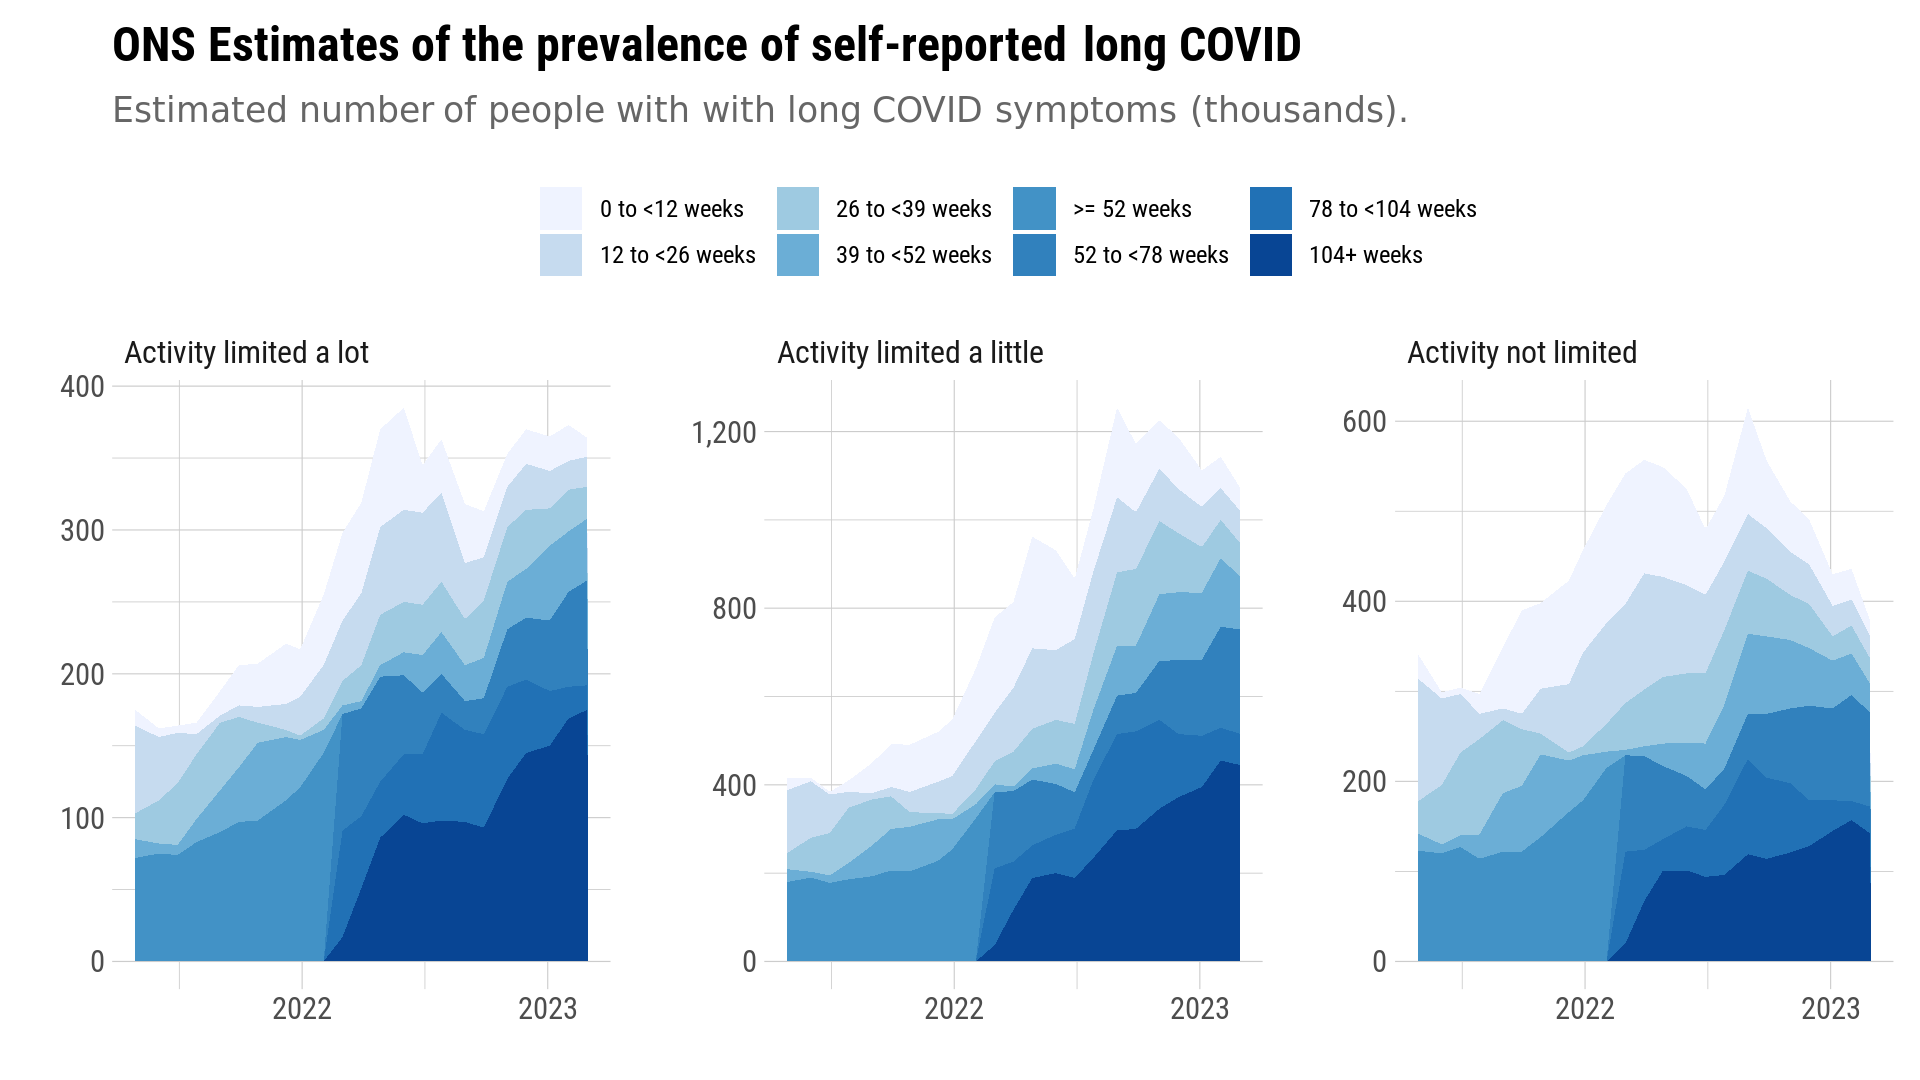

In [11]:
s = 1.25
options(repr.plot.width = s*8, repr.plot.height = s*4.5, repr.plot.res = 240/s)

df2%>%
  mutate(Date = ISOweek::ISOweek2date(paste0(Year, "-W", str_pad(Week, width = 2, pad = "0"), "-3")))%>%
  mutate(`Impact on daily activity` = factor(`Impact on daily activity`, levels = rev(levels)))%>%
  ggplot(aes(x = Date, y = Estimate, fill = reorder(Group, parse_number(Group)))) + 
  labs(title = "ONS Estimates of the prevalence of self-reported long COVID",
       subtitle = "Estimated number of people with with long COVID symptoms (thousands).",
       fill = "", x = "", y = "") +
  geom_area() +
  scale_fill_manual(values = pal) +
  scale_x_date(date_breaks = "1 year", date_labels = "%Y") +
  scale_y_continuous(labels = scales::comma) +
  facet_wrap(~`Impact on daily activity`, ncol = 3, scale = "free_y") +
  theme(legend.position  = "top") +
  savePlot("ONS_LC_estimate3")


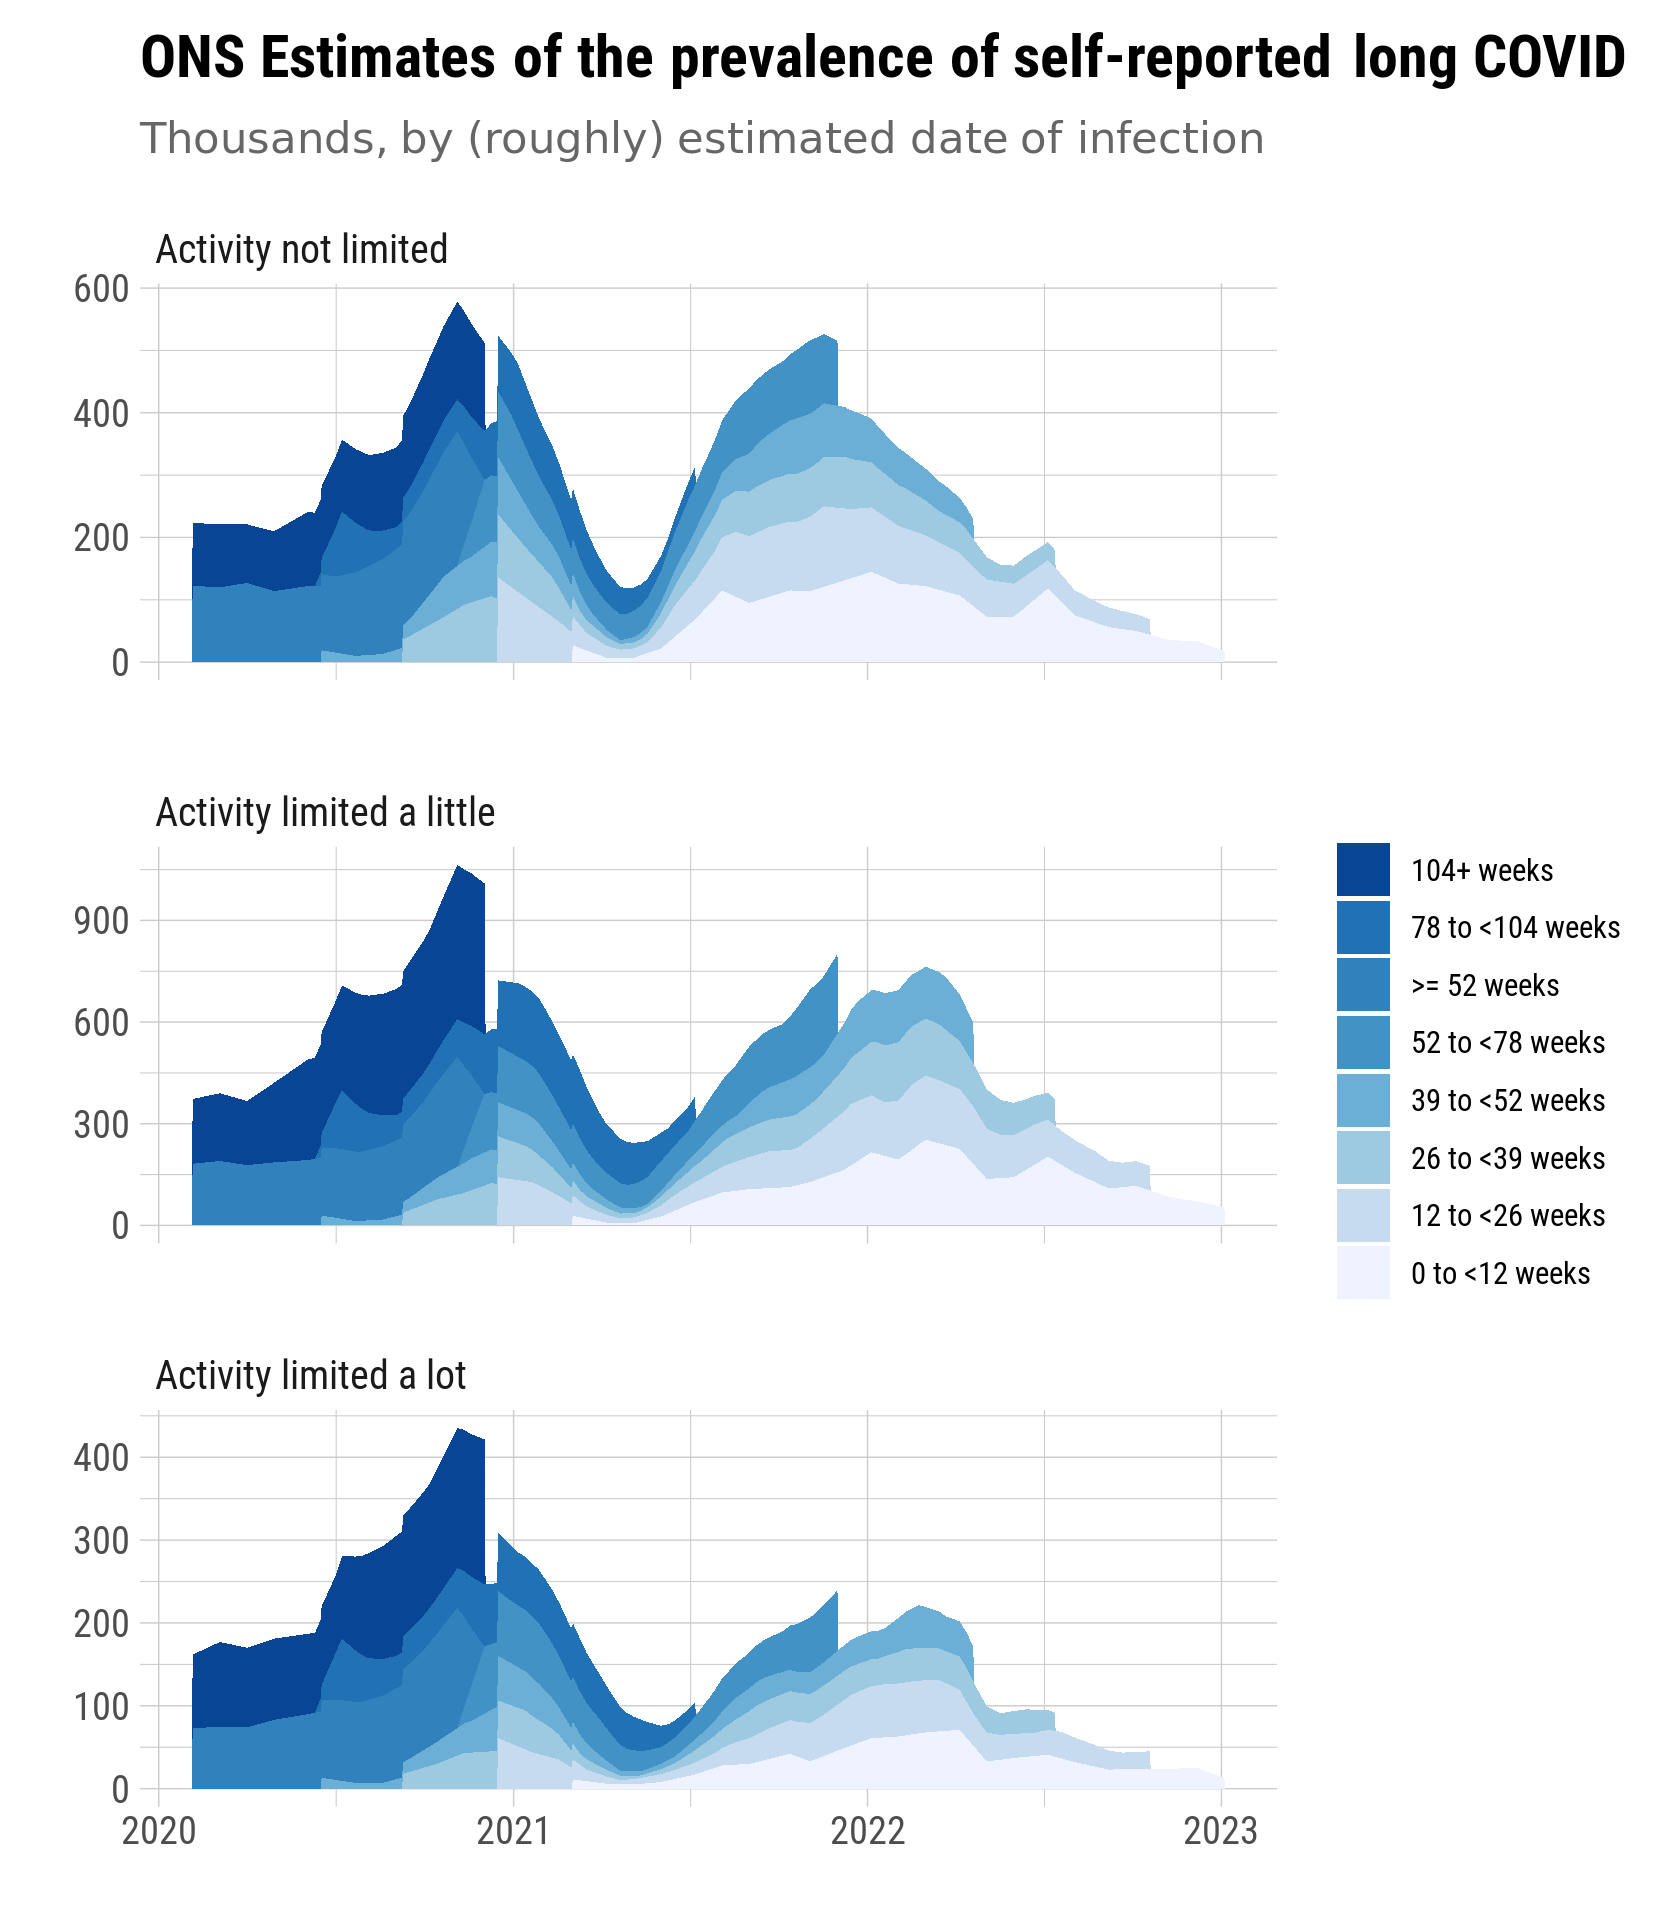

In [7]:
s = 1
options(repr.plot.width = s*7, repr.plot.height = s*8, repr.plot.res = 240/s)

df2%>%
  mutate(Date = ISOweek::ISOweek2date(paste0(Year, "-W", str_pad(Week, width = 2, pad = "0"), "-3")))%>%
  mutate(middle = case_when(Group=="0 to <12 weeks"~4,
                         Group=="12 to <26 weeks"~19,
                         Group=="26 to <39 weeks"~33,
                         Group=="39 to <52 weeks"~45,
                         Group=="52 to <78 weeks"~65,
                         Group==">= 52 weeks"~65,
                         Group=="78 to <104 weeks"~91,
                         Group=="104+ weeks"~117,
                        T~NA))%>%
  mutate(InfectionDate = Date-middle*7)%>%
  filter(InfectionDate>="2020-02-01")%>%
  ggplot(aes(x = InfectionDate, y = Estimate, fill = reorder(Group, -parse_number(Group)))) + 
  labs(title = "ONS Estimates of the prevalence of self-reported long COVID",
       subtitle = "Thousands, by (roughly) estimated date of infection",
       fill = "", x = "", y = "") +
  geom_area() +
  scale_fill_manual(values = rev(pal)) +
  scale_y_continuous(labels = scales::comma) +
  facet_wrap(~`Impact on daily activity`, ncol = 1, scale = "free_y") 